# Conditional Diffusion Models from Scratch: MNIST

## Introduction

Build a **Conditional Denoising Diffusion Probabilistic Model** that can generate specific digits on demand!

### What Makes It "Conditional"?
Unlike standard diffusion models that generate random samples, conditional diffusion models can:
- **Control generation**: Specify what digit to generate (0-9)
- **Guided sampling**: Condition on class labels during training and inference
- **Targeted outputs**: Generate exactly what you want

### How It Works
1. **Training**: Learn to denoise images while knowing their class labels
2. **Conditioning**: Embed class labels and combine with time embeddings
3. **Generation**: Provide a class label to generate that specific digit

### What You'll Build
- Conditional diffusion model from scratch
- Train on MNIST digits (0-9)
- Generate specific digits on demand
- Compare conditional vs unconditional generation

Let's begin! 🚀

## 1. Setup and Imports

In [ ]:
# Install required packages
!pip install -q torch torchvision matplotlib tqdm pillow numpy

print("✓ Packages installed!")

✓ Packages installed!


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import math

# Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

# Set seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda
PyTorch version: 2.8.0+cu126


## 2. Configuration

In [2]:
# Model hyperparameters
image_size = 28  # MNIST native size
channels = 1  # Grayscale
num_classes = 10  # Digits 0-9
batch_size = 128

# Diffusion hyperparameters
timesteps = 1000
beta_start = 0.0001
beta_end = 0.02

# Training hyperparameters
num_epochs = 20  # Increase for better results
learning_rate = 1e-3

# Conditioning
class_emb_dim = 128  # Dimension for class embeddings

print(f"Configuration:")
print(f"  Image size: {image_size}x{image_size}")
print(f"  Number of classes: {num_classes}")
print(f"  Class embedding dim: {class_emb_dim}")
print(f"  Diffusion steps: {timesteps}")
print(f"  Training epochs: {num_epochs}")

Configuration:
  Image size: 28x28
  Number of classes: 10
  Class embedding dim: 128
  Diffusion steps: 1000
  Training epochs: 20


## 3. Load MNIST Dataset

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 15.0MB/s]


Dataset loaded: 60000 images
Number of batches: 469


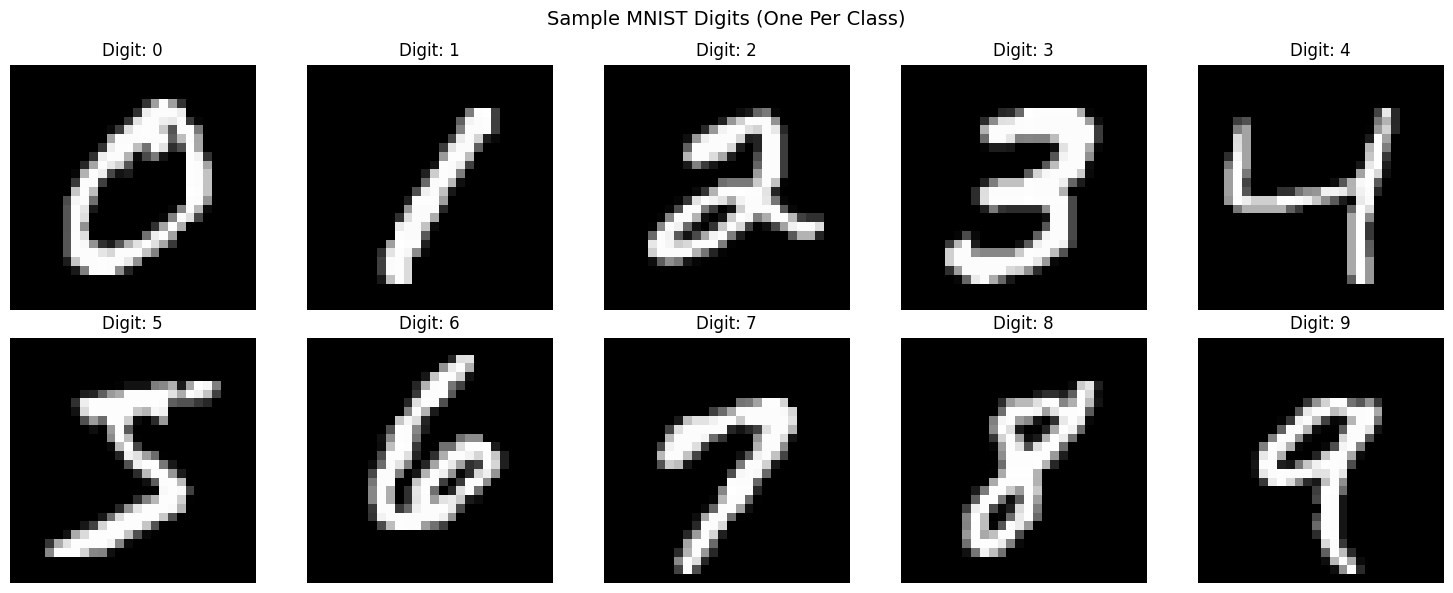

In [3]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Scale to [-1, 1]
])

# Load dataset
dataset = MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print(f"Dataset loaded: {len(dataset)} images")
print(f"Number of batches: {len(dataloader)}")

# Visualize samples from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for digit in range(10):
    # Find first image of this digit
    for img, label in dataset:
        if label == digit:
            img_to_show = (img + 1) / 2  # [-1, 1] -> [0, 1]
            axes[digit].imshow(img_to_show.squeeze(), cmap='gray')
            axes[digit].set_title(f"Digit: {digit}", fontsize=12)
            axes[digit].axis('off')
            break

plt.suptitle("Sample MNIST Digits (One Per Class)", fontsize=14)
plt.tight_layout()
plt.show()

## 4. Noise Schedule (Same as Before)

In [4]:
def create_noise_schedule(timesteps, beta_start, beta_end):
    """Create linear noise schedule."""
    betas = torch.linspace(beta_start, beta_end, timesteps)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

    return {
        'betas': betas,
        'alphas': alphas,
        'alphas_cumprod': alphas_cumprod,
        'alphas_cumprod_prev': alphas_cumprod_prev,
        'sqrt_alphas_cumprod': sqrt_alphas_cumprod,
        'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
        'sqrt_recip_alphas': sqrt_recip_alphas,
        'posterior_variance': posterior_variance,
    }

noise_schedule = create_noise_schedule(timesteps, beta_start, beta_end)
print("✓ Noise schedule created")

✓ Noise schedule created


## 5. Forward Diffusion

In [5]:
def forward_diffusion_sample(x_0, t, noise_schedule, device="cpu"):
    """Add noise to images at timestep t."""
    noise = torch.randn_like(x_0)

    # Convert t to CPU for indexing since noise_schedule is on CPU
    t_cpu = t.cpu()
    sqrt_alphas_cumprod_t = noise_schedule['sqrt_alphas_cumprod'][t_cpu].to(device)
    sqrt_one_minus_alphas_cumprod_t = noise_schedule['sqrt_one_minus_alphas_cumprod'][t_cpu].to(device)

    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod_t[:, None, None, None]
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod_t[:, None, None, None]

    noisy_images = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise

    return noisy_images, noise

print("✓ Forward diffusion function defined")

✓ Forward diffusion function defined


In [ ]:
noisy_images, noise = forward_diffusion_sample(img, 1000, )

AttributeError: 'int' object has no attribute 'cpu'

## 6. Conditional U-Net Architecture

Key additions for conditioning:
1. **Class Embedding Layer**: Convert class labels to embeddings
2. **Combined Conditioning**: Merge class embeddings with time embeddings
3. **Conditional Blocks**: Pass conditioning through all network layers

In [ ]:
class TimeEmbedding(nn.Module):
    """Sinusoidal time embedding."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat([embeddings.sin(), embeddings.cos()], dim=-1)
        return embeddings


class ConditionalBlock(nn.Module):
    """Residual block with time and class conditioning."""
    def __init__(self, in_ch, out_ch, cond_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)

        # Conditioning MLP (combines time + class embeddings)
        self.cond_mlp = nn.Sequential(
            nn.Linear(cond_dim, out_ch),
            nn.SiLU(),
            nn.Linear(out_ch, out_ch)
        )

        self.bn1 = nn.GroupNorm(8, out_ch)
        self.bn2 = nn.GroupNorm(8, out_ch)

        if in_ch != out_ch:
            self.residual_conv = nn.Conv2d(in_ch, out_ch, 1)
        else:
            self.residual_conv = nn.Identity()

    def forward(self, x, cond):
        """
        Args:
            x: Input features
            cond: Conditioning (time + class embeddings concatenated)
        """
        h = self.conv1(x)
        h = self.bn1(h)
        h = F.relu(h)

        # Add conditioning
        cond_emb = self.cond_mlp(cond)
        h = h + cond_emb[:, :, None, None]

        h = self.conv2(h)
        h = self.bn2(h)
        h = F.relu(h)

        return h + self.residual_conv(x)


class ConditionalUNet(nn.Module):
    """
    Conditional U-Net for class-conditional diffusion on 28x28 images.
    Uses 2 downsampling steps to avoid size mismatch issues.
    """
    def __init__(self, in_channels=1, out_channels=1, num_classes=10,
                 time_emb_dim=128, class_emb_dim=128):
        super().__init__()

        # Embeddings
        self.time_embedding = TimeEmbedding(time_emb_dim)
        self.class_embedding = nn.Embedding(num_classes, class_emb_dim)

        # Conditioning dimension (time + class)
        cond_dim = time_emb_dim + class_emb_dim

        # Encoder (downsampling) - only 2 levels for 28x28
        self.enc1 = ConditionalBlock(in_channels, 64, cond_dim)    # 28x28
        self.down1 = nn.Conv2d(64, 64, 4, 2, 1)                    # -> 14x14

        self.enc2 = ConditionalBlock(64, 128, cond_dim)            # 14x14
        self.down2 = nn.Conv2d(128, 128, 4, 2, 1)                  # -> 7x7

        # Bottleneck
        self.bottleneck = ConditionalBlock(128, 256, cond_dim)     # 7x7

        # Decoder (upsampling)
        self.up2 = nn.ConvTranspose2d(256, 128, 4, 2, 1)           # -> 14x14
        self.dec2 = ConditionalBlock(256, 128, cond_dim)           # 128 from up + 128 from enc2

        self.up1 = nn.ConvTranspose2d(128, 64, 4, 2, 1)            # -> 28x28
        self.dec1 = ConditionalBlock(128, 64, cond_dim)            # 64 from up + 64 from enc1

        # Output
        self.out = nn.Conv2d(64, out_channels, 1)

    def forward(self, x, t, y):
        """
        Args:
            x: Noisy images [batch_size, C, H, W]
            t: Timesteps [batch_size]
            y: Class labels [batch_size]
        """
        # Create conditioning vector (time + class)
        t_emb = self.time_embedding(t)
        y_emb = self.class_embedding(y)
        cond = torch.cat([t_emb, y_emb], dim=-1)

        # Encoder
        e1 = self.enc1(x, cond)                 # 28x28 x 64
        x = self.down1(e1)                       # 14x14 x 64

        e2 = self.enc2(x, cond)                 # 14x14 x 128
        x = self.down2(e2)                       # 7x7 x 128

        # Bottleneck
        x = self.bottleneck(x, cond)            # 7x7 x 256

        # Decoder with skip connections
        x = self.up2(x)                          # 14x14 x 128
        x = torch.cat([x, e2], dim=1)           # 14x14 x 256
        x = self.dec2(x, cond)                  # 14x14 x 128

        x = self.up1(x)                          # 28x28 x 64
        x = torch.cat([x, e1], dim=1)           # 28x28 x 128
        x = self.dec1(x, cond)                  # 28x28 x 64

        return self.out(x)                       # 28x28 x out_channels

# Create model
model = ConditionalUNet(
    in_channels=channels,
    out_channels=channels,
    num_classes=num_classes,
    class_emb_dim=class_emb_dim
).to(device)

print(f"✓ Conditional model created")
print(f"  Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test forward pass
test_input = torch.randn(2, channels, image_size, image_size).to(device)
test_t = torch.randint(0, timesteps, (2,)).to(device)
test_y = torch.randint(0, num_classes, (2,)).to(device)
test_output = model(test_input, test_t, test_y)
print(f"  Test input shape: {test_input.shape}")
print(f"  Test output shape: {test_output.shape}")
print(f"  Test class labels: {test_y.tolist()}")
assert test_output.shape == test_input.shape, "Output shape mismatch!"
print(f"  ✓ Shape test passed!")

✓ Conditional model created
  Parameters: 3,039,169
  Test input shape: torch.Size([2, 1, 28, 28])
  Test output shape: torch.Size([2, 1, 28, 28])
  Test class labels: [2, 1]
  ✓ Shape test passed!


## 7. Training Loop (with Class Conditioning)

Starting training...


Epoch 1/20: 100%|██████████| 469/469 [00:24<00:00, 19.05it/s, loss=0.0315]


Epoch 1/20 - Average Loss: 0.0732


Epoch 2/20: 100%|██████████| 469/469 [00:24<00:00, 19.29it/s, loss=0.0241]


Epoch 2/20 - Average Loss: 0.0323


Epoch 3/20: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s, loss=0.0283]


Epoch 3/20 - Average Loss: 0.0280


Epoch 4/20: 100%|██████████| 469/469 [00:24<00:00, 19.32it/s, loss=0.0247]


Epoch 4/20 - Average Loss: 0.0261


Epoch 5/20: 100%|██████████| 469/469 [00:24<00:00, 19.31it/s, loss=0.0155]


Epoch 5/20 - Average Loss: 0.0250


Epoch 6/20: 100%|██████████| 469/469 [00:24<00:00, 19.29it/s, loss=0.0298]


Epoch 6/20 - Average Loss: 0.0246


Epoch 7/20: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s, loss=0.0291]


Epoch 7/20 - Average Loss: 0.0243


Epoch 8/20: 100%|██████████| 469/469 [00:20<00:00, 23.42it/s, loss=0.0214]


Epoch 8/20 - Average Loss: 0.0240


Epoch 9/20: 100%|██████████| 469/469 [00:11<00:00, 42.21it/s, loss=0.0251]


Epoch 9/20 - Average Loss: 0.0239


Epoch 10/20: 100%|██████████| 469/469 [00:11<00:00, 41.45it/s, loss=0.0216]


Epoch 10/20 - Average Loss: 0.0232


Epoch 11/20: 100%|██████████| 469/469 [00:11<00:00, 40.36it/s, loss=0.0219]


Epoch 11/20 - Average Loss: 0.0234


Epoch 12/20: 100%|██████████| 469/469 [00:12<00:00, 37.33it/s, loss=0.0220]


Epoch 12/20 - Average Loss: 0.0230


Epoch 13/20: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s, loss=0.0203]


Epoch 13/20 - Average Loss: 0.0230


Epoch 14/20: 100%|██████████| 469/469 [00:12<00:00, 37.68it/s, loss=0.0229]


Epoch 14/20 - Average Loss: 0.0229


Epoch 15/20: 100%|██████████| 469/469 [00:10<00:00, 42.70it/s, loss=0.0274]


Epoch 15/20 - Average Loss: 0.0228


Epoch 16/20: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s, loss=0.0238]


Epoch 16/20 - Average Loss: 0.0225


Epoch 17/20: 100%|██████████| 469/469 [00:17<00:00, 27.08it/s, loss=0.0215]


Epoch 17/20 - Average Loss: 0.0228


Epoch 18/20: 100%|██████████| 469/469 [00:12<00:00, 37.19it/s, loss=0.0260]


Epoch 18/20 - Average Loss: 0.0224


Epoch 19/20: 100%|██████████| 469/469 [00:11<00:00, 41.59it/s, loss=0.0294]


Epoch 19/20 - Average Loss: 0.0224


Epoch 20/20: 100%|██████████| 469/469 [00:15<00:00, 30.47it/s, loss=0.0219]


Epoch 20/20 - Average Loss: 0.0226

✓ Training complete!


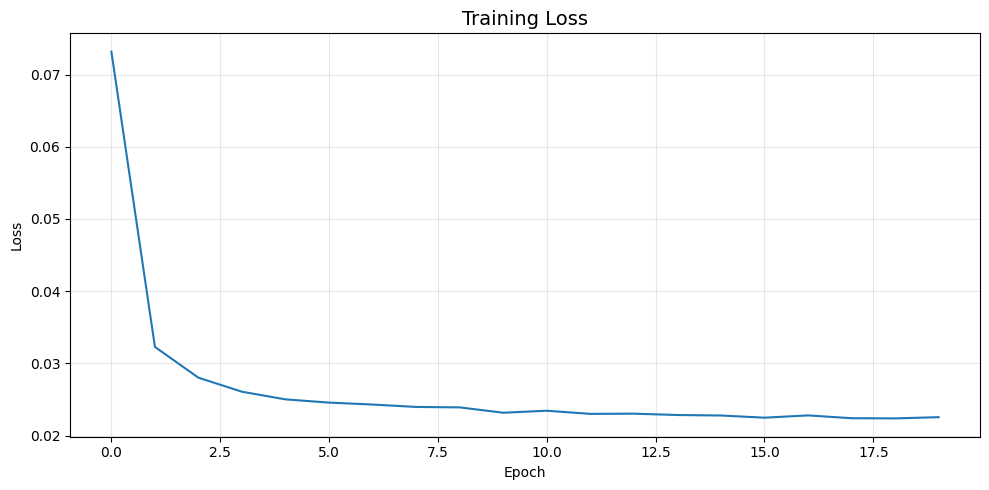

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

losses = []

print("Starting training...")
print("=" * 80)

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch_idx, (images, labels) in enumerate(progress_bar):
        images = images.to(device)
        labels = labels.to(device)  # Class labels
        batch_size_current = images.shape[0]

        # Sample random timesteps
        t = torch.randint(0, timesteps, (batch_size_current,), device=device)

        # Forward diffusion: add noise
        noisy_images, noise = forward_diffusion_sample(images, t, noise_schedule, device)

        # Predict noise (conditioned on class labels!)
        predicted_noise = model(noisy_images, t, labels)

        # Calculate loss
        loss = criterion(predicted_noise, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

print("\n" + "=" * 80)
print("✓ Training complete!")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.title("Training Loss", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Conditional Sampling (Generate Specific Digits!)

The key feature: generate specific digits by providing class labels.

In [ ]:
@torch.no_grad()
def conditional_sample(model, noise_schedule, class_labels, image_size=28, channels=1, device="cpu"):
    """
    Generate images conditioned on class labels.

    Args:
        model: Trained conditional U-Net
        noise_schedule: Noise schedule
        class_labels: Tensor of class labels [n_samples]
        image_size: Image size
        channels: Number of channels
        device: Device

    Returns:
        Generated images
    """
    model.eval()

    n_samples = len(class_labels)

    # Start from pure noise
    x = torch.randn(n_samples, channels, image_size, image_size).to(device)

    timesteps_list = list(range(timesteps))[::-1]

    for t_idx in tqdm(timesteps_list, desc="Sampling"):
        t = torch.full((n_samples,), t_idx, device=device, dtype=torch.long)

        # Predict noise (conditioned on class!)
        predicted_noise = model(x, t, class_labels)

        # Get schedule values
        alpha = noise_schedule['alphas'][t_idx].to(device)
        alpha_cumprod = noise_schedule['alphas_cumprod'][t_idx].to(device)
        beta = noise_schedule['betas'][t_idx].to(device)

        if t_idx > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        # Reverse diffusion step
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / torch.sqrt(1 - alpha_cumprod)) * predicted_noise)
        x = x + torch.sqrt(beta) * noise

    model.train()
    return x

print("✓ Conditional sampling function defined")

✓ Conditional sampling function defined


## 9. Generate Specific Digits

Generating 10 samples of each digit...
Class labels shape: torch.Size([100])
Generating 100 images...


Sampling: 100%|██████████| 1000/1000 [00:05<00:00, 175.05it/s]


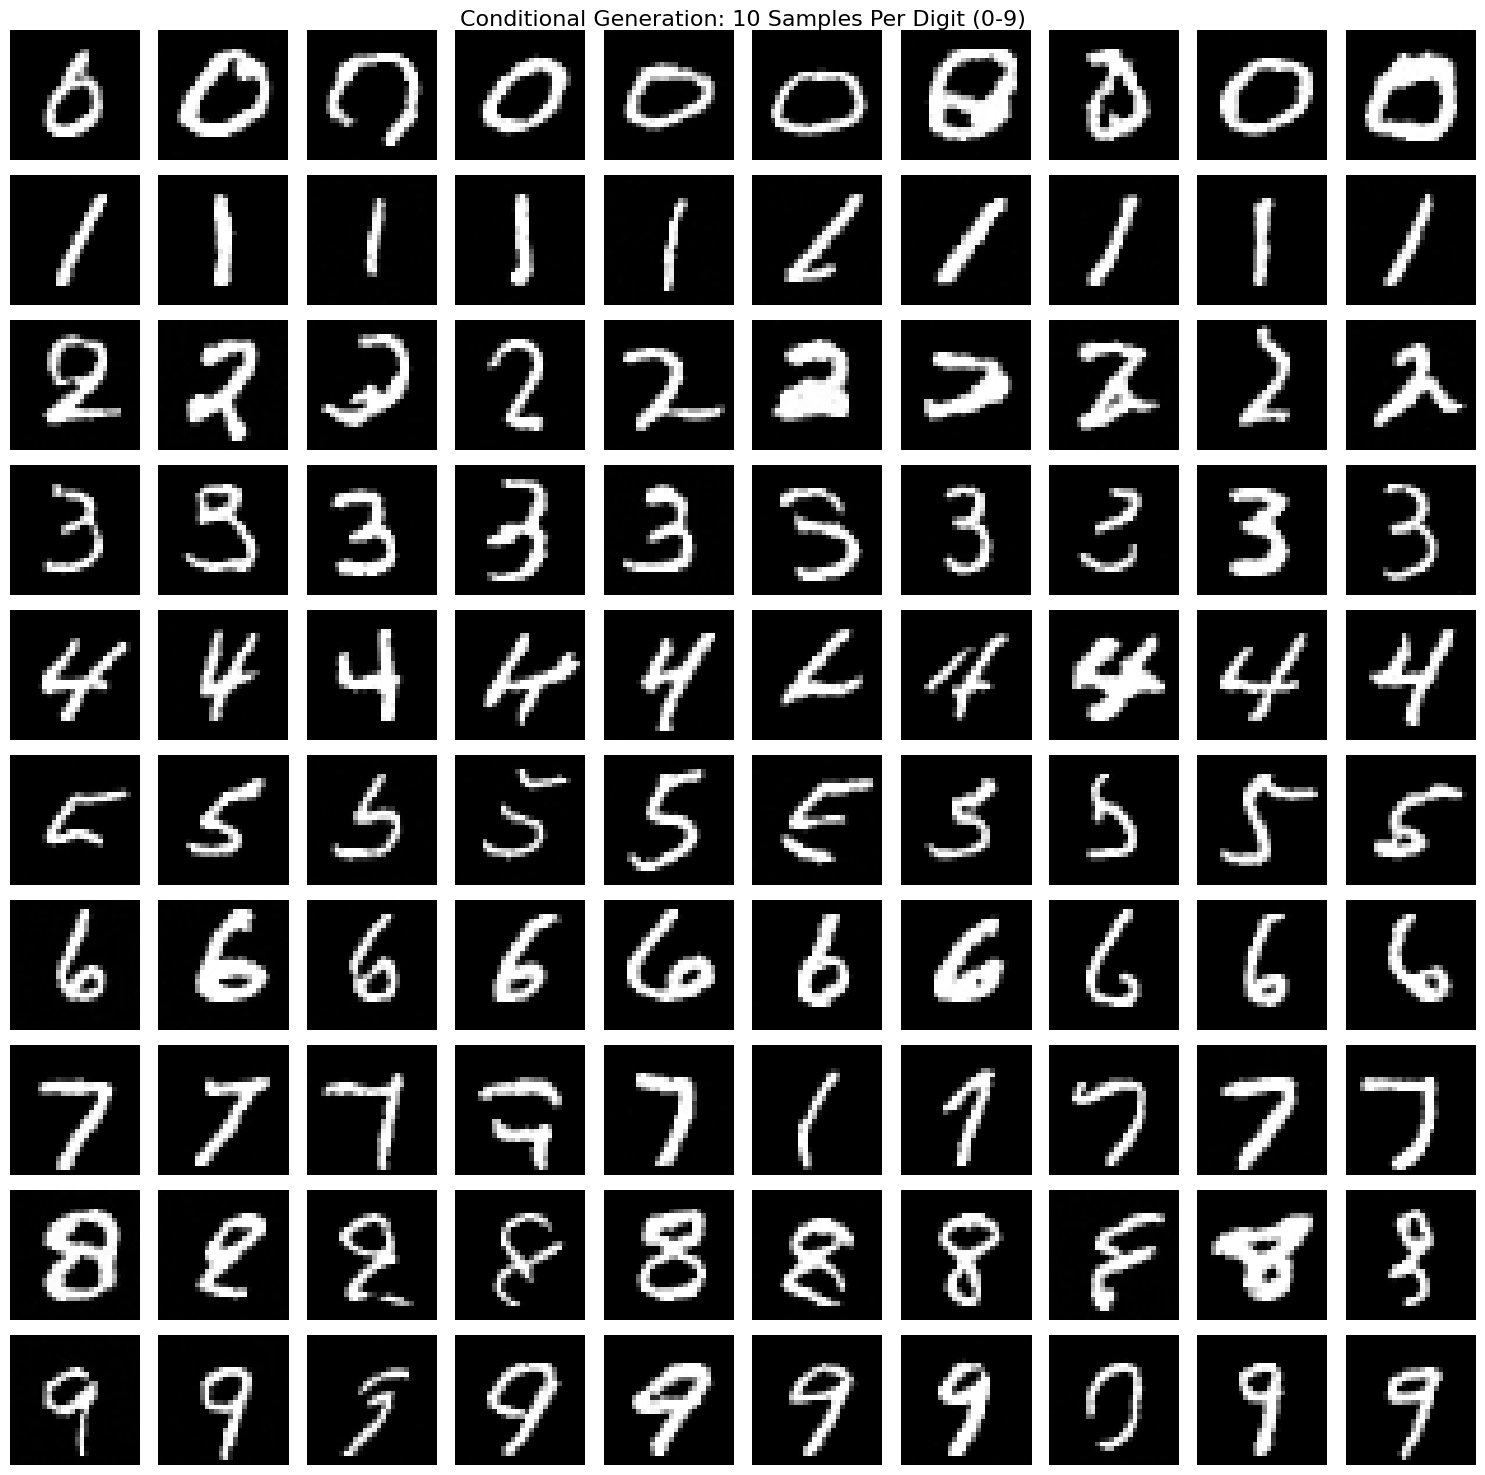

✓ Generation complete!


In [ ]:
# Generate 10 samples of each digit (0-9)
print("Generating 10 samples of each digit...")

# Create class labels: [0, 0, ..., 1, 1, ..., 9, 9]
samples_per_class = 10
class_labels = torch.tensor(
    [i for i in range(num_classes) for _ in range(samples_per_class)],
    device=device
)

print(f"Class labels shape: {class_labels.shape}")
print(f"Generating {len(class_labels)} images...")

generated_images = conditional_sample(
    model,
    noise_schedule,
    class_labels,
    image_size,
    channels,
    device
)

# Denormalize
generated_images = (generated_images + 1) / 2  # [-1, 1] -> [0, 1]
generated_images = torch.clamp(generated_images, 0, 1)

# Visualize: 10 rows (one per digit), 10 columns (samples)
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

for digit in range(10):
    for sample in range(10):
        idx = digit * 10 + sample
        axes[digit, sample].imshow(generated_images[idx].cpu().squeeze(), cmap='gray')
        axes[digit, sample].axis('off')
        if sample == 0:
            axes[digit, sample].set_ylabel(f"Digit {digit}", fontsize=12, rotation=0, labelpad=30)

plt.suptitle("Conditional Generation: 10 Samples Per Digit (0-9)", fontsize=16)
plt.tight_layout()
plt.show()

print("✓ Generation complete!")

## 10. Generate Specific Digits On Demand

Generating digits: [7, 7, 7, 7, 3, 3, 3, 3, 5, 5, 5, 5, 0, 0, 0, 0]


Sampling: 100%|██████████| 1000/1000 [00:02<00:00, 391.57it/s]


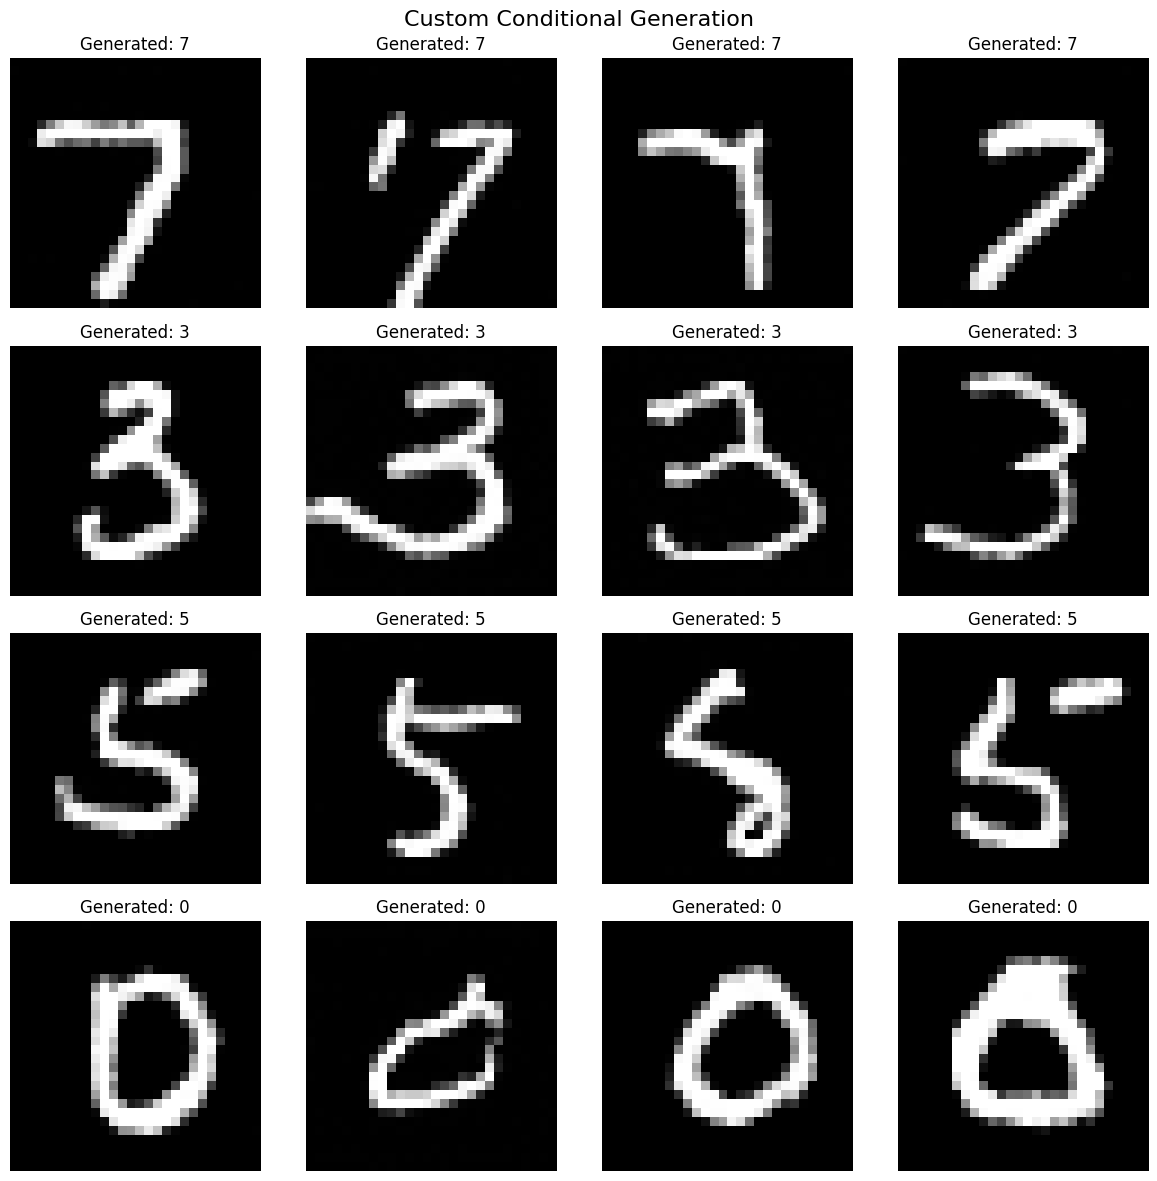

✓ Custom generation complete!

💡 Tip: Modify 'digits_to_generate' to create different digits!


In [ ]:
# ========== CUSTOMIZE THIS CELL ==========
# Choose which digits to generate!

digits_to_generate = [7, 7, 7, 7, 3, 3, 3, 3, 5, 5, 5, 5, 0, 0, 0, 0]  # Customize this!
# =========================================

print(f"Generating digits: {digits_to_generate}")

class_labels_custom = torch.tensor(digits_to_generate, device=device)

generated_custom = conditional_sample(
    model,
    noise_schedule,
    class_labels_custom,
    image_size,
    channels,
    device
)

# Denormalize
generated_custom = (generated_custom + 1) / 2
generated_custom = torch.clamp(generated_custom, 0, 1)

# Visualize
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(len(digits_to_generate)):
    axes[i].imshow(generated_custom[i].cpu().squeeze(), cmap='gray')
    axes[i].set_title(f"Generated: {digits_to_generate[i]}", fontsize=12)
    axes[i].axis('off')

plt.suptitle("Custom Conditional Generation", fontsize=16)
plt.tight_layout()
plt.show()

print("✓ Custom generation complete!")
print("\n💡 Tip: Modify 'digits_to_generate' to create different digits!")

## 11. Visualize Conditional vs Random Generation

Generating 16 variations of digit 5...


Sampling: 100%|██████████| 1000/1000 [00:02<00:00, 414.78it/s]


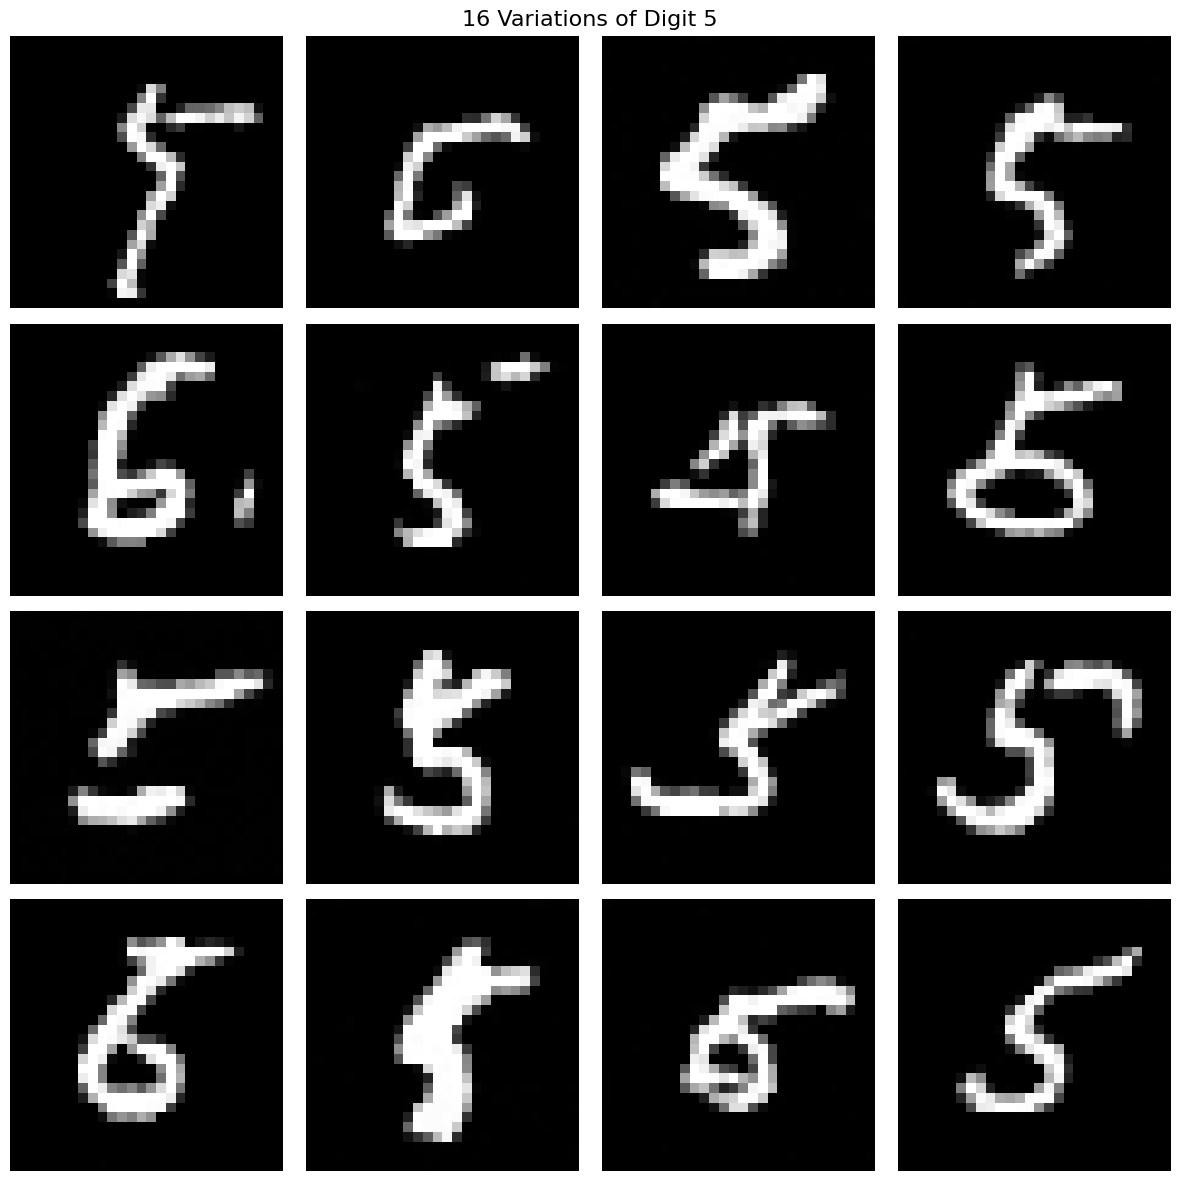

✓ Variations generated!
  Notice: Same digit, but different styles/variations!


In [ ]:
# Generate same digit multiple times to see variation
target_digit = 5
n_variations = 16

print(f"Generating {n_variations} variations of digit {target_digit}...")

class_labels_single = torch.full((n_variations,), target_digit, device=device)

variations = conditional_sample(
    model,
    noise_schedule,
    class_labels_single,
    image_size,
    channels,
    device
)

variations = (variations + 1) / 2
variations = torch.clamp(variations, 0, 1)

# Visualize
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(n_variations):
    axes[i].imshow(variations[i].cpu().squeeze(), cmap='gray')
    axes[i].axis('off')

plt.suptitle(f"16 Variations of Digit {target_digit}", fontsize=16)
plt.tight_layout()
plt.show()

print("✓ Variations generated!")
print("  Notice: Same digit, but different styles/variations!")

## 12. Compare with Real MNIST Digits

Sampling: 100%|██████████| 1000/1000 [00:03<00:00, 296.01it/s]


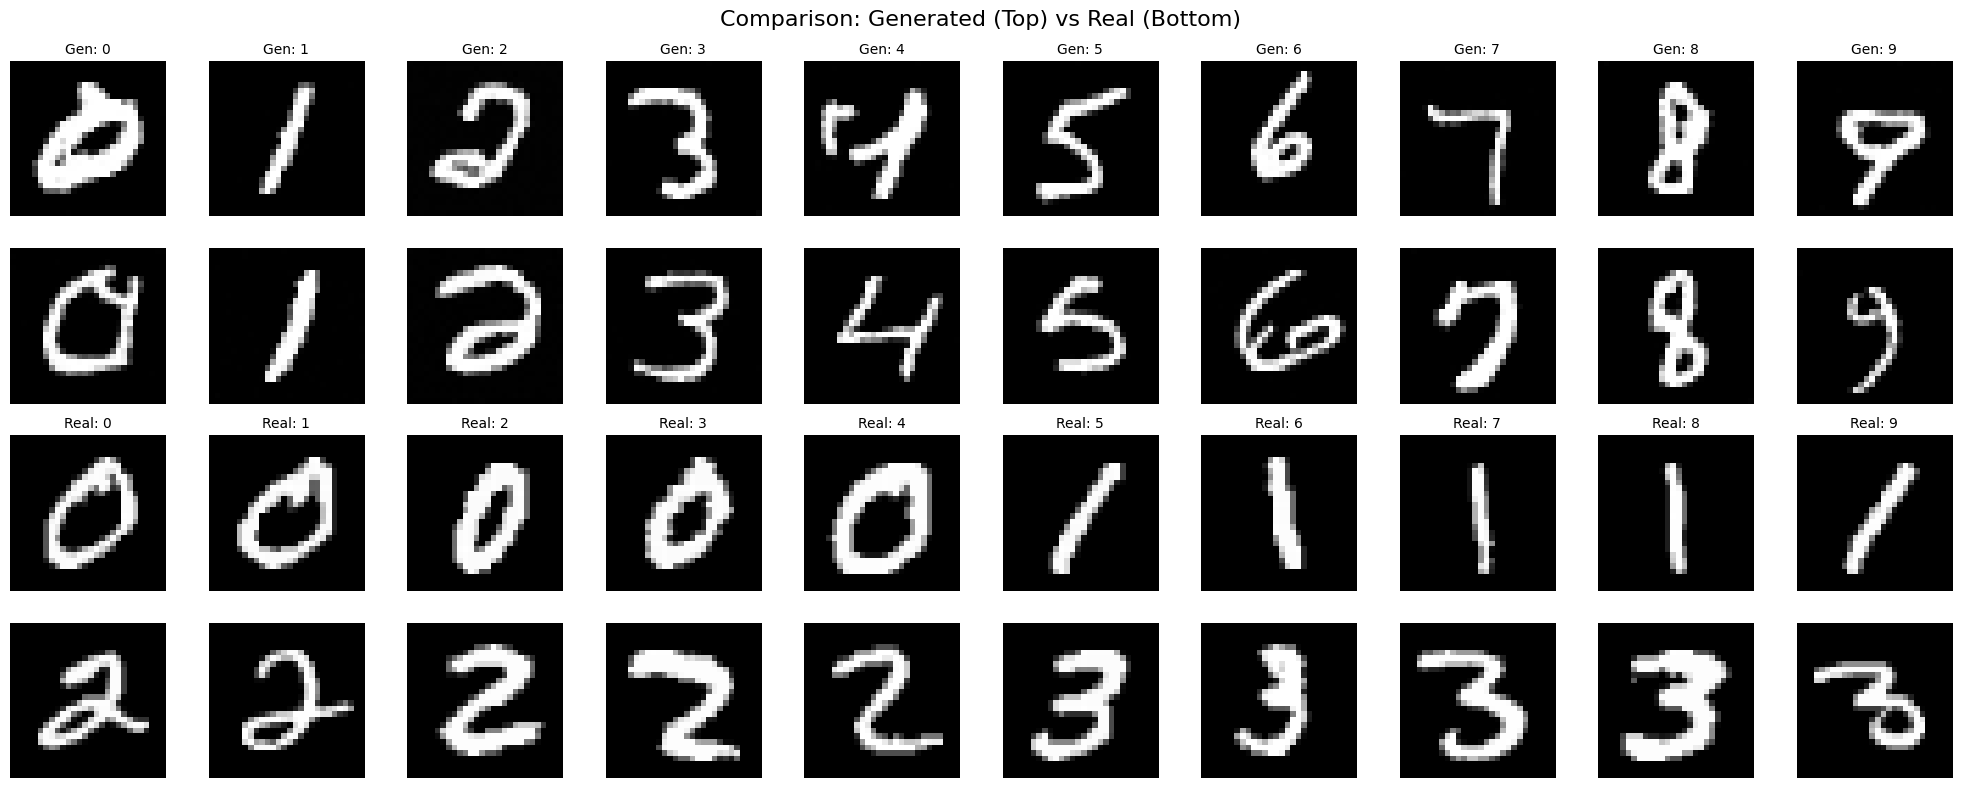

✓ Comparison complete!


In [ ]:
# Generate samples for comparison
comparison_labels = torch.arange(10, device=device).repeat(5)  # 5 samples per digit
generated_for_comparison = conditional_sample(
    model, noise_schedule, comparison_labels, image_size, channels, device
)
generated_for_comparison = (generated_for_comparison + 1) / 2
generated_for_comparison = torch.clamp(generated_for_comparison, 0, 1)

# Get real samples
real_samples = []
for digit in range(10):
    count = 0
    for img, label in dataset:
        if label == digit:
            real_samples.append(img)
            count += 1
            if count >= 5:
                break

real_samples = torch.stack(real_samples)
real_samples = (real_samples + 1) / 2

# Visualize comparison
fig, axes = plt.subplots(4, 10, figsize=(20, 8))

# Row 1-2: Generated
for i in range(20):
    row = i // 10
    col = i % 10
    axes[row, col].imshow(generated_for_comparison[i].cpu().squeeze(), cmap='gray')
    axes[row, col].axis('off')
    if row == 0:
        axes[row, col].set_title(f"Gen: {col}", fontsize=10)

# Row 3-4: Real
for i in range(20):
    row = (i // 10) + 2
    col = i % 10
    axes[row, col].imshow(real_samples[i].cpu().squeeze(), cmap='gray')
    axes[row, col].axis('off')
    if row == 2:
        axes[row, col].set_title(f"Real: {col}", fontsize=10)

plt.suptitle("Comparison: Generated (Top) vs Real (Bottom)", fontsize=16)
plt.tight_layout()
plt.show()

print("✓ Comparison complete!")

## 13. Save Model

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'noise_schedule': noise_schedule,
    'losses': losses,
    'config': {
        'num_classes': num_classes,
        'class_emb_dim': class_emb_dim,
        'image_size': image_size,
        'channels': channels,
    }
}, 'conditional_diffusion_mnist.pth')

print("✓ Model saved to 'conditional_diffusion_mnist.pth'")

✓ Model saved to 'conditional_diffusion_mnist.pth'


## 14. Summary and Key Concepts

### What We Built
✅ Conditional diffusion model from scratch
✅ Class embedding layer for conditioning
✅ Conditional U-Net architecture
✅ Training with class labels
✅ Targeted generation: Generate specific digits on demand

### Key Differences from Unconditional Diffusion

| Aspect | Unconditional | Conditional |
|--------|---------------|-------------|
| **Input** | Noisy image + time | Noisy image + time + class |
| **Training** | Predict noise from any image | Predict noise knowing the class |
| **Generation** | Random samples | Controlled samples |
| **Architecture** | Time embedding only | Time + class embeddings |
| **Use Case** | Explore possibilities | Generate specific content |

### How Conditioning Works
1. **Embedding**: Convert class label (0-9) to dense vector
2. **Fusion**: Concatenate class embedding with time embedding
3. **Propagation**: Pass combined conditioning through all layers
4. **Learning**: Model learns class-specific denoising patterns

### Applications
- **Text-to-image**: Extend to text conditioning (like Stable Diffusion)
- **Controlled generation**: Generate specific attributes
- **Data augmentation**: Create labeled training data
- **Style transfer**: Condition on style labels

### Next Steps
1. **Classifier-Free Guidance**: Improve conditioning strength
2. **Text Conditioning**: Replace class labels with text embeddings
3. **Multi-Attribute**: Condition on multiple attributes simultaneously
4. **Higher Resolution**: Scale up to larger images

### Further Reading
- [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598)
- [GLIDE](https://arxiv.org/abs/2112.10741) - Text-conditional diffusion
- [Stable Diffusion](https://arxiv.org/abs/2112.10752)
- [Imagen](https://arxiv.org/abs/2205.11487)

Congratulations! You've built a conditional diffusion model that can generate specific digits on demand! 🎉